## Exploratory Data Analysis:  Movie Ratings and Common Sense Metrics
### Import Non-text Features and convert to Pandas DataFrame for analysis

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import requests, json, csv, copy
import matplotlib.pyplot as plt
import math
import random

sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Load json of movies_features_text
with open('data/movies_other_features.json') as json_file:  
    movies_other_features = json.load(json_file)

In [3]:
df = pd.DataFrame(movies_other_features)

In [4]:
### Eliminate spaces in front of MPAA ratings, to allow handling
df.MPAA_rating = df.MPAA_rating.map(lambda x: x.strip())

In [5]:
### Eliminate spaces in front of genre, to allow handling
df.genre = df.genre.map(lambda x: x.strip())

In [6]:
### Create ordinal list of MPAA movie ratings, to facilitate recommendations
mpaa_dict = {'G':0, 'PG':1, 'PG-13':2, 'R':3, 'NR':4, 'NC-17':5}

In [7]:
### Create new feature, MPAA_ordinal
df['MPAA_ordinal'] = df['MPAA_rating'].map(lambda x: mpaa_dict[x])

In [9]:
df[0:7]

Consumerism  Drinking, Drugs & Smoking  Educational Value  Language  \
0          0.0                        3.0                NaN       0.0   
1          0.0                        4.0                NaN       4.0   
2          2.0                        4.0                NaN       4.0   
3          2.0                        0.0                NaN       3.0   
4          5.0                        3.0                NaN       3.0   
5          0.0                        0.0                NaN       1.0   
6          1.0                        0.0                2.0       1.0   

  MPAA_rating  Positive Messages  Positive Role Models & Representations  Sex  \
0          NR                4.0                                     3.0  2.0   
1          NR                3.0                                     2.0  4.0   
2           R                3.0                                     3.0  5.0   
3       PG-13                3.0                                     3.0  1.0   
4          NR                3.0                                     2.0  2.0   
5          NR                4.0                                     4.0  1.0   
6          PG                4.0                                     4.0  NaN   

   Sexy Stuff  Violence  Violence & Scariness  age             genre  \
0         NaN       0.0                   NaN   10             Drama   
1         NaN       2.0                   NaN   16             Drama   
2         NaN       4.0                   NaN   16  Action/Adventure   
3         NaN       4.0                   NaN   13   Science Fiction   
4         NaN       0.0                   NaN   15            Comedy   
5         NaN       2.0                   NaN   10             Drama   
6         1.0       NaN                   2.0    8   Family and Kids   

   movie_id                               one_line_description  \
0         0         Mild Andrea Bocelli biopic lacks momentum.   
1         1  Timely, effective YA-based tale about LGBTQ te...   
2         2  Bullets and profanity fly in feminist friendsh...   
3         3  Skilled actors can't save derivative, violent ...   
4         4  Goodhearted but predictable father-daughter co...   
5         5   Sincere, wholesome drama overcomes cliched plot.   
6         6  Sweet but slow tale about the power of family,...   

   overall_rating                              slug  \
0               2              the-music-of-silence   
1               4  the-miseducation-of-cameron-post   
2               4             the-spy-who-dumped-me   
3               2                 the-darkest-minds   
4               2                       like-father   
5               3                     urban-country   
6               3                 christopher-robin   

                              title  MPAA_ordinal  
0              The Music of Silence             4  
1  The Miseducation of Cameron Post             4  
2             The Spy Who Dumped Me             3  
3                 The Darkest Minds             2  
4                       Like Father             4  
5                     Urban Country             4  
6                 Christopher Robin             1

### Exploratory Data Analysis:

In [10]:
# All movie rating features have at least one null value. Each feature is examined in detail
# to determine how to impute values while compromising our data the least.
def find_NaNs_left_to_clean(df=df):
    return df.loc[:, df.isnull().sum() != 0].isnull().sum()

In [11]:
find_NaNs_left_to_clean(df)

Consumerism                                 58
Drinking, Drugs & Smoking                   35
Educational Value                         7373
Language                                    22
Positive Messages                          376
Positive Role Models & Representations    2146
Sex                                       2050
Sexy Stuff                                6694
Violence                                  2043
Violence & Scariness                      6677
dtype: int64

In [12]:
# Visual inspection has lead me to believe that 0. can be safely imputed for the following
# features:
feature_zero = ['Consumerism', 'Drinking, Drugs & Smoking', 'Language', 'Positive Messages', 'Sex', 'Violence']

In [13]:
for feature in feature_zero:
    df[feature].fillna(0., inplace=True)

In [14]:
find_NaNs_left_to_clean(df)

Educational Value                         7373
Positive Role Models & Representations    2146
Sexy Stuff                                6694
Violence & Scariness                      6677
dtype: int64

### Why Sexy Stuff and Sex? Violence and Violence and Scariness?
#### Movies for Young Children are evaluated using different scales than those for teens:  Sexy Stuff, and Violence & Scariness are often used as scales for marital embraces or cartoon scariness as opposed to nudity or blood and gore in Sex and Violence ratings. Sexy Stuff, Violence & Scariness, and Educational Value are only present in movies recommended for children aged 8 and younger by Common Sense Media (see below). Consequently, boolean features were created to facilitate future data handling involving these features (e.g., 'is\_educational' is a 1 when any rating was given for 'Educational Value', etc.)
#### Decision made to leave NaN's in these categories since there was no good way to impute them without destroying their reason for being.

In [15]:
### Create new column, ['is_educational'], that is 1 if any rating or 0 if NaN
df['is_educational'] = df['Educational Value'].notnull().map(int)

In [16]:
### Create new column, ['has_Sexy_Stuff'], that is 1 if any rating or 0 if NaN
df['has_Sexy_Stuff'] = df['Sexy Stuff'].notnull().map(int)

In [17]:
### Create new column, ['has_Violence_&_Scariness'], that is 1 if any rating or 0 if NaN
df['has_Violence_&_Scariness'] = df['Violence & Scariness'].notnull().map(int)

### Minimum Age Recommendations and MPAA Ratings

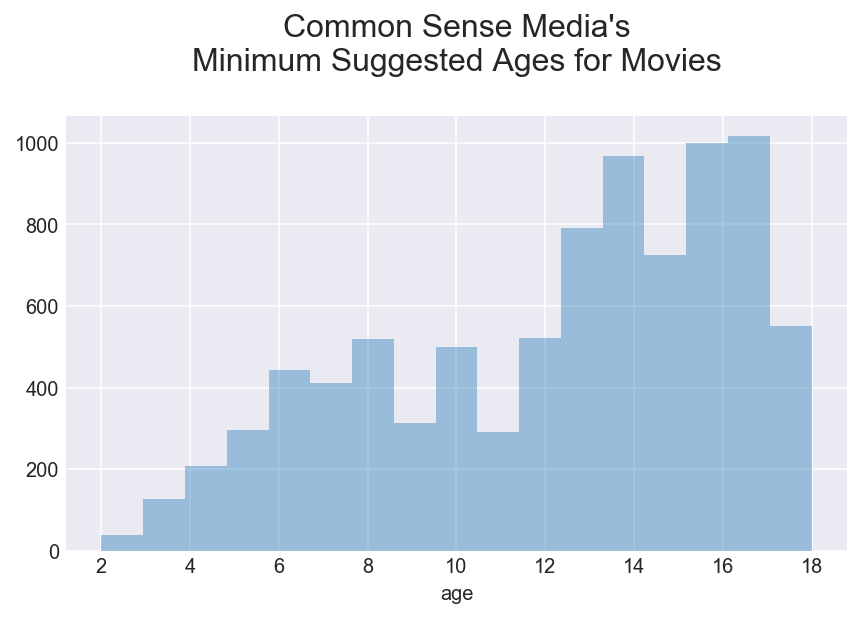

In [18]:
fig = plt.figure(figsize=(7,4))
ax = fig.gca()

ax = sns.distplot(df['age'], bins=17, kde = False)

ax.set_title('Common Sense Media\'s\nMinimum Suggested Ages for Movies\n', fontsize=16)
plt.show()

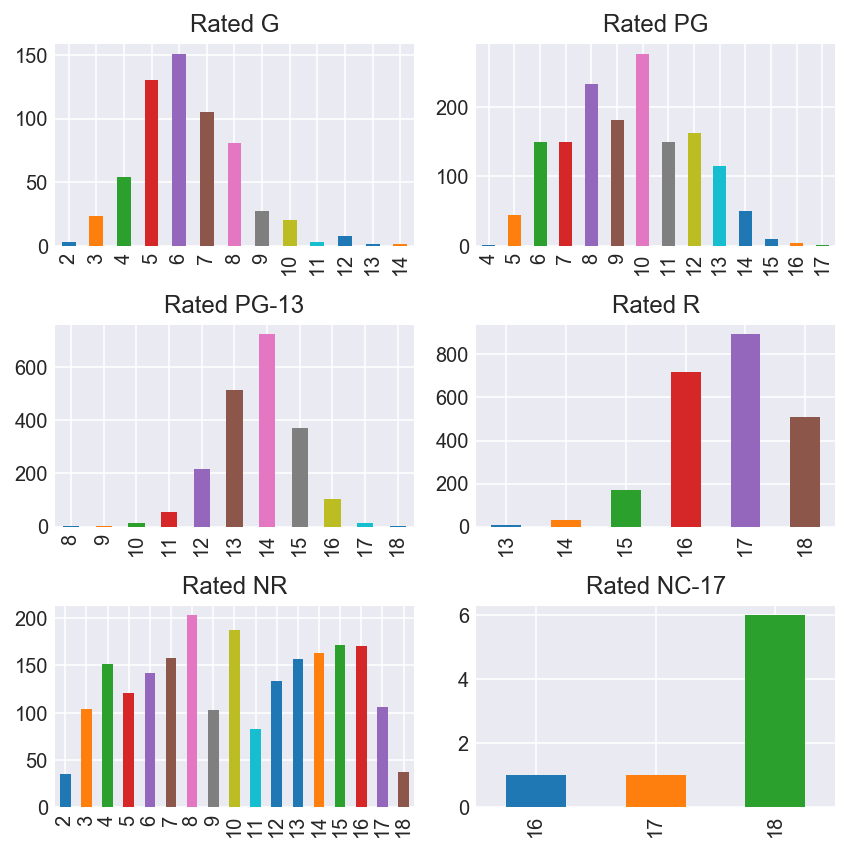

In [26]:
fig = plt.figure(figsize=(6,6))

ax1 = fig.add_subplot(321)
df[df['MPAA_rating']=='G']['age'].value_counts().sort_index().plot(kind='bar')
ax2 = fig.add_subplot(322)
df[df['MPAA_rating']=='PG']['age'].value_counts().sort_index().plot(kind='bar')
ax3 = fig.add_subplot(323)
df[df['MPAA_rating']=='PG-13']['age'].value_counts().sort_index().plot(kind='bar')
ax4 = fig.add_subplot(324)
df[df['MPAA_rating']=='R']['age'].value_counts().sort_index().plot(kind='bar')
ax5 = fig.add_subplot(325)
df[df['MPAA_rating']=='NR']['age'].value_counts().sort_index().plot(kind='bar')
ax6 = fig.add_subplot(326)
df[df['MPAA_rating']=='NC-17']['age'].value_counts().sort_index().plot(kind='bar')

ax1.title.set_text('Rated G')
ax2.title.set_text('Rated PG')
ax3.title.set_text('Rated PG-13')
ax4.title.set_text('Rated R')
ax5.title.set_text('Rated NR')
ax6.title.set_text('Rated NC-17')

fig.tight_layout()
plt.show();


In [27]:
df[df['MPAA_rating']=='G']['age'].mean()

6.308072487644152

In [28]:
df[df['MPAA_rating']=='PG']['age'].mean()

9.46043165467626

In [29]:
df[df['MPAA_rating']=='PG-13']['age'].mean()

13.725285643318431

In [30]:
df[df['MPAA_rating']=='R']['age'].mean()

16.71017604121941

In [31]:
df[df['MPAA_rating']=='NR']['age'].describe()

count    2228.000000
mean       10.144524
std         4.396873
min         2.000000
25%         7.000000
50%        10.000000
75%        14.000000
max        18.000000
Name: age, dtype: float64

In [32]:
df[df['MPAA_rating']=='NC-17']['age'].mean()

17.625

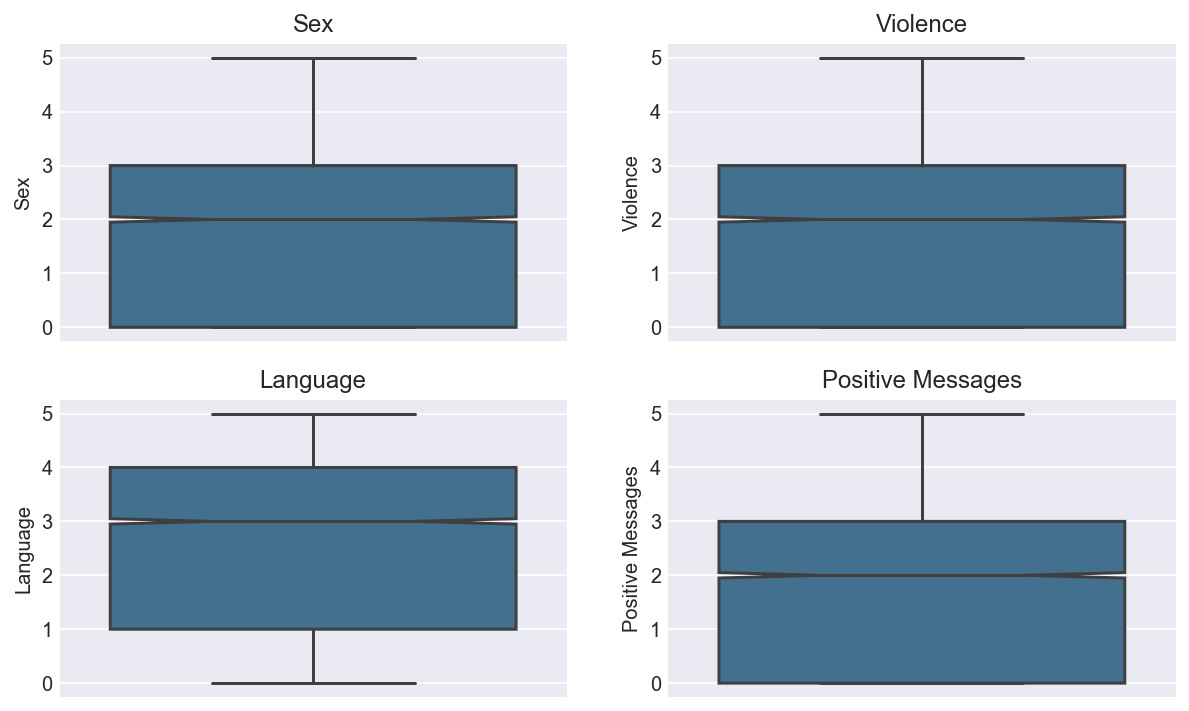

In [33]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(221)
sns.boxplot(df['Sex'],
           orient='v',
           fliersize=8,
           linewidth=1.5,
           notch=True,
           saturation=0.5)
ax2 = fig.add_subplot(222)
sns.boxplot(df['Violence'],
           orient='v',
           fliersize=8,
           linewidth=1.5,
           notch=True,
           saturation=0.5)
ax3 = fig.add_subplot(223)
sns.boxplot(df['Language'],
           orient='v',
           fliersize=8,
           linewidth=1.5,
           notch=True,
           saturation=0.5)
ax4 = fig.add_subplot(224)
sns.boxplot(df['Positive Messages'],
           orient='v',
           fliersize=8,
           linewidth=1.5,
           notch=True,
           saturation=0.5)
ax1.title.set_text('Sex')
ax2.title.set_text('Violence')
ax3.title.set_text('Language')
ax4.title.set_text('Positive Messages')
plt.show()

fig.tight_layout();

In [34]:
df['Educational Value'].value_counts()

0.0    526
1.0    432
2.0    202
3.0    105
4.0     55
5.0     21
Name: Educational Value, dtype: int64

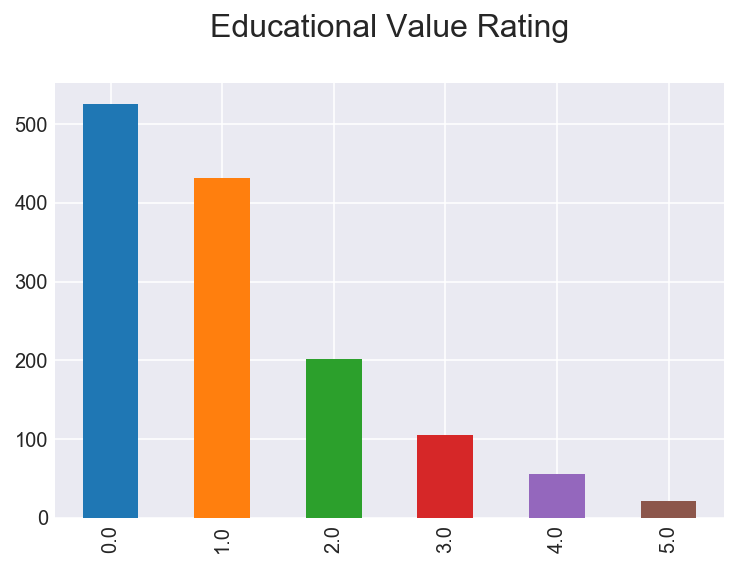

In [35]:
ax = df['Educational Value'].value_counts().plot(kind='bar')
ax.set_title("Educational Value Rating\n", fontsize=16)
fig.tight_layout();

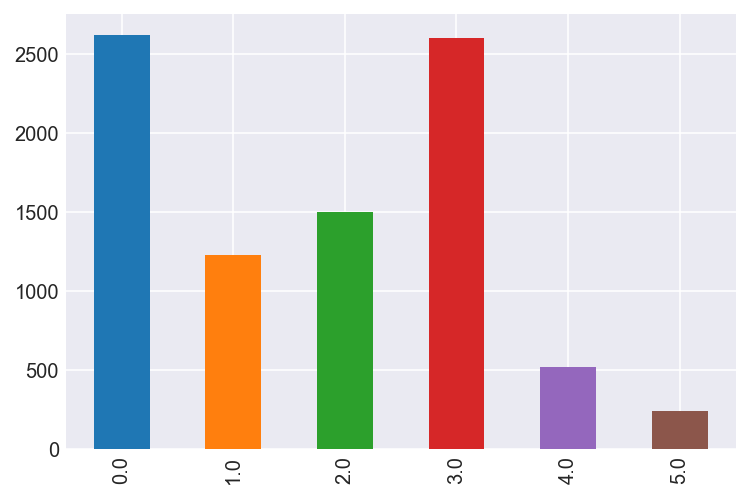

In [36]:
df['Drinking, Drugs & Smoking'].value_counts().sort_index().plot(kind='bar')

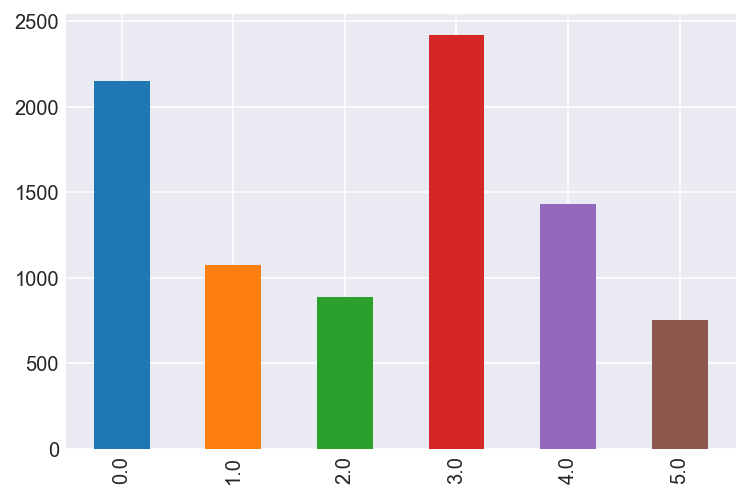

In [37]:
df['Language'].value_counts().sort_index().plot(kind='bar')

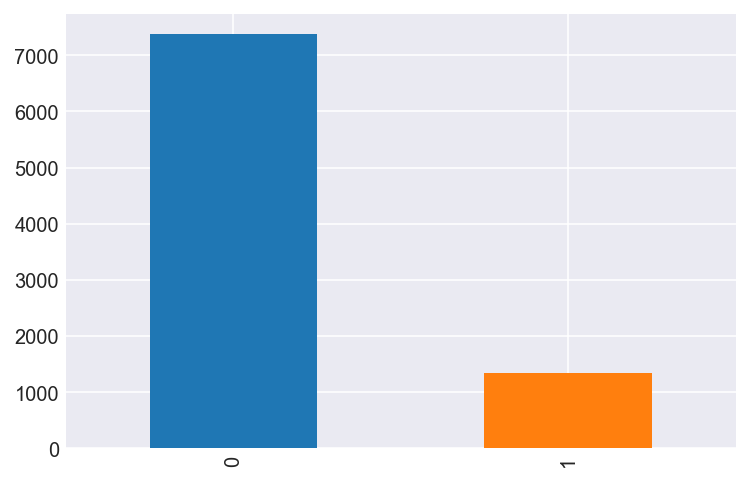

In [38]:
df['is_educational'].value_counts().plot(kind='bar')

In [39]:
df[df['is_educational'] ==1]['age'].describe()

count    1341.000000
mean        6.017897
std         1.584809
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max         8.000000
Name: age, dtype: float64

### Sexy Stuff

In [40]:
df['Sexy Stuff'].value_counts()

0.0    1344
1.0     539
2.0     112
3.0      25
Name: Sexy Stuff, dtype: int64

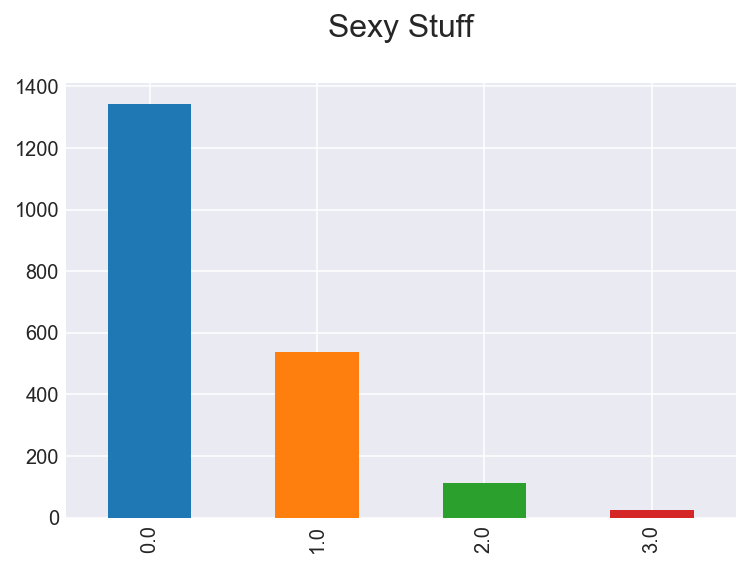

In [41]:
ax = df['Sexy Stuff'].value_counts().plot(kind='bar')
ax.set_title("Sexy Stuff\n", fontsize=16)
fig.tight_layout();

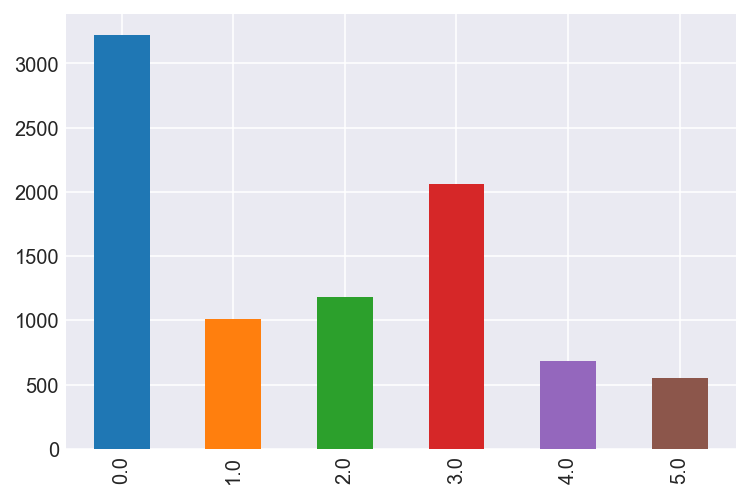

In [42]:
df['Sex'].value_counts().sort_index().plot(kind='bar')

In [43]:
df[df['has_Sexy_Stuff'] ==1]['age'].describe()

count    2020.000000
mean        6.115842
std         1.607759
min         2.000000
25%         5.000000
50%         6.000000
75%         8.000000
max         8.000000
Name: age, dtype: float64

### Violence & Scariness

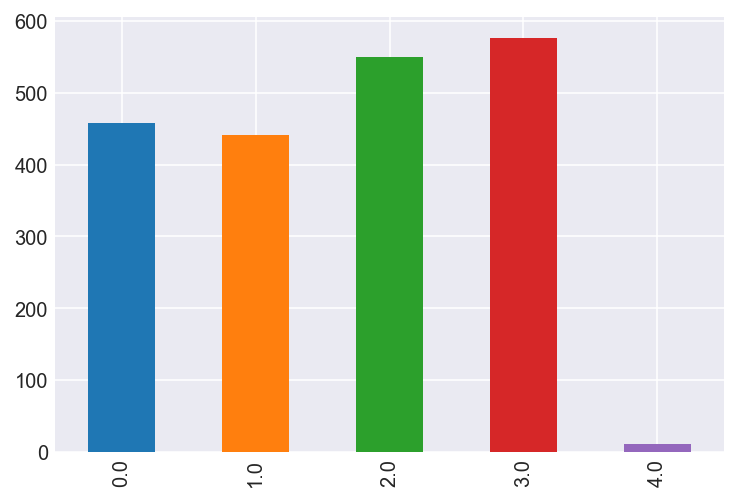

In [44]:
df['Violence & Scariness'].value_counts().sort_index().plot(kind='bar')

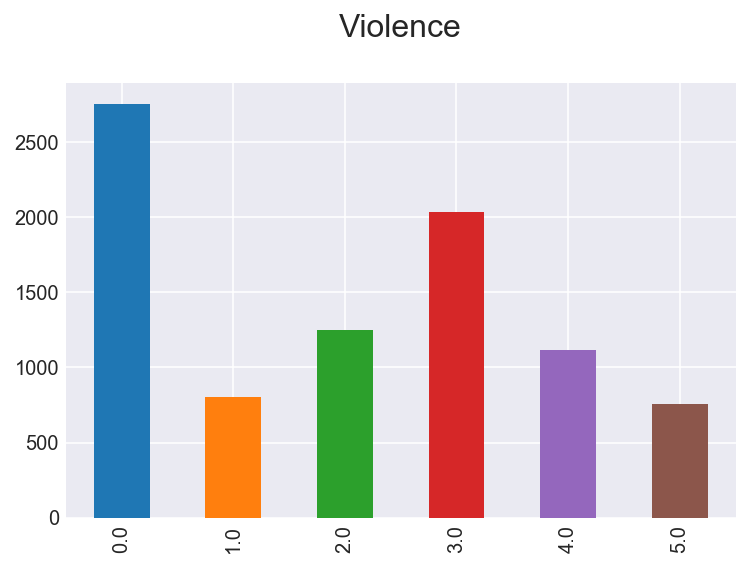

In [45]:
ax = df['Violence'].value_counts().sort_index().plot(kind='bar')
ax.set_title("Violence\n", fontsize=16)
fig.tight_layout();

In [46]:
df[df['has_Violence_&_Scariness'] ==1]['age'].describe()

count    2037.000000
mean        6.104075
std         1.615546
min         2.000000
25%         5.000000
50%         6.000000
75%         8.000000
max         8.000000
Name: age, dtype: float64

#### Visual inspection of a subset of movies with a NaN for Sex and any value for Sexy Stuff revealed that Sexy Stuff does not even rise to a 1 on the Sex meter. These should also be set to zero. Likewise, nothing on the Violence & Scariness scale rose to even a 1 on the Violence metric, so these can safely be set to zero as well.

In [47]:
df['Sex'].fillna(0., inplace=True)
df['Violence'].fillna(0., inplace=True)

### Positive Role Models & Representations

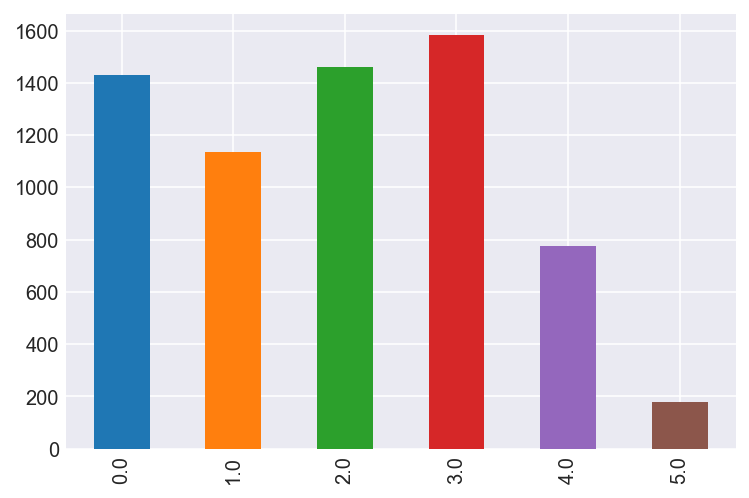

In [48]:
df['Positive Role Models & Representations'].value_counts().sort_index().plot(kind='bar')

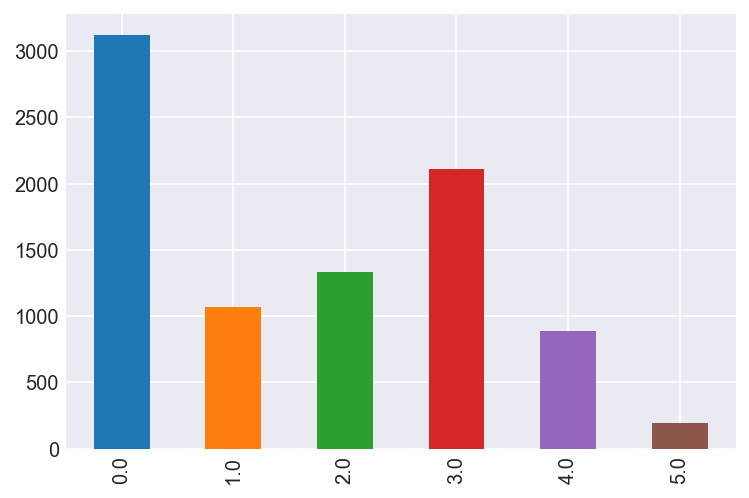

In [49]:
df['Positive Messages'].value_counts().sort_index().plot(kind='bar')

In [50]:
### Create new column, ['has_Positive_Role_Models_&_Representations'],
### that is 1 if any rating or 0 if NaN
for movie in range(len(df)):
    if math.isnan(df['Positive Role Models & Representations'][movie]) == True:
        df.loc[movie, 'has_Positive_Role_Models_&_Representations'] = 0
    else:
        df.loc[movie, 'has_Positive_Role_Models_&_Representations']= 1

In [51]:
df[df['has_Positive_Role_Models_&_Representations'] ==1]['age'].describe()

count    6568.000000
mean       12.133069
std         4.135030
min         2.000000
25%         9.000000
50%        13.000000
75%        16.000000
max        18.000000
Name: age, dtype: float64

In [52]:
df[df['Positive Role Models & Representations'].isnull()]

Consumerism  Drinking, Drugs & Smoking  Educational Value  Language  \
422           3.0                        0.0                2.0       1.0   
665           2.0                        0.0                0.0       0.0   
2346          1.0                        3.0                NaN       3.0   
2847          2.0                        0.0                0.0       1.0   
4119          0.0                        0.0                NaN       0.0   
4190          0.0                        3.0                NaN       0.0   
4370          3.0                        3.0                NaN       0.0   
4378          3.0                        3.0                NaN       0.0   
4393          0.0                        0.0                NaN       0.0   
4400          0.0                        0.0                NaN       0.0   
4444          0.0                        3.0                NaN       0.0   
4475          0.0                        0.0                NaN       0.0   
4476          0.0                        3.0                NaN       3.0   
4491          0.0                        2.0                NaN       2.0   
4510          0.0                        3.0                NaN       3.0   
4511          0.0                        0.0                NaN       3.0   
4539          3.0                        1.0                NaN       3.0   
4547          1.0                        0.0                3.0       0.0   
4554          3.0                        2.0                NaN       3.0   
4565          0.0                        3.0                NaN       0.0   
4573          2.0                        0.0                NaN       1.0   
4580          0.0                        0.0                NaN       4.0   
4581          1.0                        2.0                NaN       2.0   
4586          3.0                        3.0                NaN       3.0   
4588          0.0                        0.0                NaN       0.0   
4595          0.0                        3.0                NaN       0.0   
4602          0.0                        0.0                NaN       0.0   
4605          2.0                        2.0                NaN       2.0   
4613          1.0                        2.0                NaN       4.0   
4614          0.0                        2.0                NaN       4.0   
...           ...                        ...                ...       ...   
8647          0.0                        3.0                NaN       0.0   
8648          0.0                        0.0                NaN       0.0   
8649          0.0                        0.0                NaN       3.0   
8651          0.0                        0.0                NaN       3.0   
8652          0.0                        3.0                NaN       0.0   
8653          0.0                        0.0                NaN       0.0   
8654          0.0                        3.0                NaN       5.0   
8658          0.0                        3.0                NaN       3.0   
8659          0.0                        0.0                NaN       0.0   
8661          0.0                        0.0                NaN       0.0   
8663          0.0                        0.0                NaN       3.0   
8664          0.0                        0.0                NaN       0.0   
8666          0.0                        2.0                NaN       0.0   
8667          0.0                        0.0                NaN       3.0   
8671          0.0                        0.0                NaN       0.0   
8672          0.0                        0.0                NaN       3.0   
8675          0.0                        0.0                NaN       3.0   
8678          0.0                        3.0                NaN       0.0   
8679          0.0                        0.0                NaN       0.0   
8680          3.0                        3.0                NaN       3.0   
86

#### No discernable pattern to null values in these movies for Positive Role Models & Representations. Decided to drop this variable entirely as including it may lead to false recommendations.

In [53]:
df.drop(columns='Positive Role Models & Representations', inplace=True)

In [54]:
df.drop(columns='has_Positive_Role_Models_&_Representations', inplace=True)

#### Save df for next notebook:  develop non-text filter to augment recommender system, indexing by movie title.

In [55]:
# movies_processed_nontext_features.set_index('title', inplace=True)

In [56]:
movies_processed_nontext_features = df

In [57]:
movies_processed_nontext_features.to_csv('data/movies_processed_nontext_features.csv')

In [58]:
movies_processed_nontext_features.head()

Consumerism  Drinking, Drugs & Smoking  Educational Value  Language  \
0          0.0                        3.0                NaN       0.0   
1          0.0                        4.0                NaN       4.0   
2          2.0                        4.0                NaN       4.0   
3          2.0                        0.0                NaN       3.0   
4          5.0                        3.0                NaN       3.0   

  MPAA_rating  Positive Messages  Sex  Sexy Stuff  Violence  \
0          NR                4.0  2.0         NaN       0.0   
1          NR                3.0  4.0         NaN       2.0   
2           R                3.0  5.0         NaN       4.0   
3       PG-13                3.0  1.0         NaN       4.0   
4          NR                3.0  2.0         NaN       0.0   

   Violence & Scariness            ...                        genre movie_id  \
0                   NaN            ...                        Drama        0   
1                   NaN            ...                        Drama        1   
2                   NaN            ...             Action/Adventure        2   
3                   NaN            ...              Science Fiction        3   
4                   NaN            ...                       Comedy        4   

                                one_line_description overall_rating  \
0         Mild Andrea Bocelli biopic lacks momentum.              2   
1  Timely, effective YA-based tale about LGBTQ te...              4   
2  Bullets and profanity fly in feminist friendsh...              4   
3  Skilled actors can't save derivative, violent ...              2   
4  Goodhearted but predictable father-daughter co...              2   

                               slug                             title  \
0              the-music-of-silence              The Music of Silence   
1  the-miseducation-of-cameron-post  The Miseducation of Cameron Post   
2             the-spy-who-dumped-me             The Spy Who Dumped Me   
3                 the-darkest-minds                 The Darkest Minds   
4                       like-father                       Like Father   

  MPAA_ordinal  is_educational  has_Sexy_Stuff  has_Violence_&_Scariness  
0            4               0               0                         0  
1            4               0               0                         0  
2            3               0               0                         0  
3            2               0               0                         0  
4            4               0               0                         0  

[5 rows x 21 columns]